## Visualise read identity against truth


### Workflow
1. Generate 50 reads of 100bp in 50bp increments, using `generate_reads.ipynb`
1. Create R9 squiggle and R10 squiggle for each read
1. Basecall that with I guess the latest dorado at this point
1. Map them back to the reference to confirm the accuracy of the mapping
1. Map them back to the original read to calculate identity.

#### TODO
Append leading prefix onto R9 data


In [2]:
import collections
import csv
import random
import re
import time as t
from contextlib import contextmanager, redirect_stdout
from io import StringIO
from itertools import islice
from pathlib import Path
from random import sample

import mappy as mp
import numpy as np
import numpy.typing as npt
import seaborn as sns
from make_squiggle import get_sequence, progress_bar_setup
from pyfastx import Fasta
from mappy import fastx_read
from pyguppy_client_lib import helper_functions
from pyguppy_client_lib.pyclient import PyGuppyClient

TEST_FASTA = Path("../fasta/identity_fasta.fasta")
R9_OUTDIR = Path("r9_squiggle")
R10_SQUIGGLE_OUTDIR = Path("r10_squiggle")
BIN_PATH = "/usr/bin/"
RANGE = 1
DIGITISATION = 8192
R10_KMERS_MODEL = Path("identity_static/R10_model.tsv")
SAMPLES = (9,10)

In [80]:
# Generate reads
fa = Fasta(
    "../fasta/hg38_no_alts.part_NC_000020.11 Homo sapiens chromosome 20, GRCh38.p14 Primary Assembly.fa.gz"
)
random.seed(1)
# Generate 10 incrementally long reads 500 bases at a time
read_length_inc = 50
reads = []
for i in range(1, 51):
    # Actually i've decided against Ns in the sequence as they make identity harder
    # So let's loop and break if the chosen sequence doesn't have any Ns
    while True:
        read_length = read_length_inc * i
        read_start = random.randint(0, 1000000)
        seq = fa[0][read_start : read_start + read_length]
        if "N" not in seq:
            reads.append(f">test_read_{i}_{read_start}_{read_start+read_length}\n{seq}")
            break
test_fasta = "\n".join(reads)
try:
    with open(TEST_FASTA, "x") as fh:
        fh.write(test_fasta)
except FileExistsError:
    print("test file already exists")

test file already exists


### helpers for base calling

In [3]:
def pack(read: dict[str, str | npt.NDArray[np.int16]]):
    """Pack an ont_fast5_api.Fast5Read for calling
    passed dict has two fields, read_id and raw_Data
    read_id: str, raw_data: npt.NDArray[np.int16]
    """
    read_id = read["read_id"]
    raw_data = read["raw_data"]
    scaling = RANGE / DIGITISATION
    offset = 0.0
    return helper_functions.package_read(read_id, raw_data, offset, scaling)

In [4]:
@contextmanager
def start_guppy_server_and_client(bin_path, config, port, server_args):
    # server_args.extend(
    #     ["--config", config, "--port", port, "--log_path", str((Path(".") / "junk"))]
    # )
    # # This function has it's own prints that may want to be suppressed
    # with redirect_stdout(StringIO()) as fh:
    #     server, port = helper_functions.run_server(server_args, bin_path=bin_path)

    # if port == "ERROR":
    #     raise RuntimeError("Server couldn't be started")

    if port.startswith("ipc"):
        address = f"{port}"
    else:
        address = f"localhost:{port}"
    client = PyGuppyClient(address=address, config=config)

    try:
        with client:
            yield client
    finally:
        server.terminate()

In [5]:
def calculate_identity(cigar: str, goal_length: int):
    match = re.findall(r"(\d+)([MIDNSHP=X])", cigar)

    # Calculate total matches, mismatches, and alignment length
    total_matches = sum(int(length) for length, operation in match if operation == "M")
    alignment_length = sum(
        int(length) for length, operation in match if operation in ["M", "D", "I", "N"]
    )
    total_insertions = sum(
        int(length) for length, operation in match if operation == "I"
    )

    # Calculate total query length (alignment length + insertions)
    total_query_length = goal_length + total_insertions

    # Identity is calculated as the number of matches divided by total query length
    identity = total_matches / total_query_length if total_query_length > 0 else 0
    return identity


# Example Usage
cigar_string = "10M6M"  # Example CIGAR string
identity = calculate_identity(cigar_string, 20)
print(f"Identity: {identity}")

Identity: 0.8


### Create R9 squiggle

In [6]:
# make directory if it doesn't already exist
R9_OUTDIR.mkdir(exist_ok=True)
job_progress, overall_progress, progress_table, task_lookup = progress_bar_setup(1)
barcode = None
get_sequence(
    TEST_FASTA.resolve(),
    R9_OUTDIR,
    job_progress,
    task_lookup,
    0,
    barcode,
    None,
)

[12/11/23 15:21:05] INFO     Generating squiggle for test_read_1_140891_140941                 ]8;id=797911;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=481929;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=878264;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=960778;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_1_140891_140941, removing them                                              

                    INFO     Generating squiggle for test_read_2_596853_596953                 ]8;id=194936;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=659924;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Generating squiggle for test_read_3_888598_888748                 ]8;id=779245;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=348856;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Generating squiggle for test_read_4_841235_841435                 ]8;id=981929;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=442611;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Generating squiggle for test_read_5_800875_801125                 ]8;id=199071;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=318104;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=887302;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=986619;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_5_800875_801125, removing them                                              

                    INFO     Generating squiggle for test_read_6_267459_267759                 ]8;id=36202;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=503554;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=434439;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=697034;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_6_267459_267759, removing them                                              

                    INFO     Generating squiggle for test_read_7_123646_123996                 ]8;id=737191;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=813524;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=460284;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=696000;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_7_123646_123996, removing them                                              

                    INFO     Generating squiggle for test_read_8_519501_519901                 ]8;id=546243;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=880753;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=31011;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=492117;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_8_519501_519901, removing them                                              

                    INFO     Generating squiggle for test_read_9_797926_798376                 ]8;id=644675;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=621998;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=176783;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=526635;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_9_797926_798376, removing them                                              

                    INFO     Generating squiggle for test_read_10_471325_471825                ]8;id=565829;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=964780;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=538728;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=360527;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_10_471325_471825, removing them                                             

                    INFO     Generating squiggle for test_read_11_495185_495735                ]8;id=481434;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=953947;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=764831;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=5986;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_11_495185_495735, removing them                                             

                    INFO     Generating squiggle for test_read_12_683244_683844                ]8;id=929226;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=984045;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=543873;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=815160;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_12_683244_683844, removing them                                             

                    INFO     Generating squiggle for test_read_13_398055_398705                ]8;id=58849;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=504471;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=209546;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=986724;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_13_398055_398705, removing them                                             

                    INFO     Generating squiggle for test_read_14_827036_827736                ]8;id=374121;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=434555;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=653776;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=824646;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_14_827036_827736, removing them                                             

                    INFO     Generating squiggle for test_read_15_220153_220903                ]8;id=29333;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=843652;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=612851;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=189565;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_15_220153_220903, removing them                                             

                    INFO     Generating squiggle for test_read_16_98418_99218                  ]8;id=835817;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=892625;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of test_read_16_98418_99218, ]8;id=882633;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=989405;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             removing them                                                                         

                    INFO     Generating squiggle for test_read_17_511554_512404                ]8;id=17501;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=475003;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=261681;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=281691;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_17_511554_512404, removing them                                             

                    INFO     Generating squiggle for test_read_18_936710_937610                ]8;id=361153;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=304385;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=552998;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=998199;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_18_936710_937610, removing them                                             

                    INFO     Generating squiggle for test_read_19_876363_877313                ]8;id=746156;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=308798;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=496784;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=119737;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_19_876363_877313, removing them                                             

                    INFO     Generating squiggle for test_read_20_408744_409744                ]8;id=441365;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=834879;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=943528;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=765620;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_20_408744_409744, removing them                                             

                    INFO     Generating squiggle for test_read_21_453789_454839                ]8;id=856728;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=21829;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=37042;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=753753;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_21_453789_454839, removing them                                             

                    INFO     Generating squiggle for test_read_22_636944_638044                ]8;id=711118;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=447390;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=836565;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=728813;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_22_636944_638044, removing them                                             

                    INFO     Generating squiggle for test_read_23_799308_800458                ]8;id=680008;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=32191;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=336850;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=691875;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_23_799308_800458, removing them                                             

                    INFO     Generating squiggle for test_read_24_804423_805623                ]8;id=313111;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=131788;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=74162;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=900217;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_24_804423_805623, removing them                                             

                    INFO     Generating squiggle for test_read_25_729633_730883                ]8;id=312349;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=779974;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=136725;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=8892;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_25_729633_730883, removing them                                             

                    INFO     Generating squiggle for test_read_26_467022_468322                ]8;id=619272;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=859217;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=179848;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=868129;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_26_467022_468322, removing them                                             

                    INFO     Generating squiggle for test_read_27_279267_280617                ]8;id=653223;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=533592;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=103835;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=215756;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_27_279267_280617, removing them                                             

                    INFO     Generating squiggle for test_read_28_756589_757989                ]8;id=620137;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=203548;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=409008;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=310454;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_28_756589_757989, removing them                                             

                    INFO     Generating squiggle for test_read_29_840775_842225                ]8;id=641863;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=913961;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=164590;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=210609;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_29_840775_842225, removing them                                             

                    INFO     Generating squiggle for test_read_30_239874_241374                ]8;id=820720;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=141707;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=707217;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=101088;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_30_239874_241374, removing them                                             

                    INFO     Generating squiggle for test_read_31_619869_621419                ]8;id=360552;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=958864;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=508033;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=805255;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_31_619869_621419, removing them                                             

                    INFO     Generating squiggle for test_read_32_991188_992788                ]8;id=42362;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=88793;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=564352;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=223313;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_32_991188_992788, removing them                                             

                    INFO     Generating squiggle for test_read_33_107192_108842                ]8;id=530462;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=881991;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=119446;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=305361;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_33_107192_108842, removing them                                             

                    INFO     Generating squiggle for test_read_34_945215_946915                ]8;id=817406;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=749845;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=577944;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=807668;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_34_945215_946915, removing them                                             

                    INFO     Generating squiggle for test_read_35_332849_334599                ]8;id=76748;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=398700;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=131090;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=357456;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_35_332849_334599, removing them                                             

                    INFO     Generating squiggle for test_read_36_681098_682898                ]8;id=971154;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=396403;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=593458;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=85714;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_36_681098_682898, removing them                                             

                    INFO     Generating squiggle for test_read_37_567712_569562                ]8;id=309909;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=591865;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=940320;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=290647;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_37_567712_569562, removing them                                             

                    INFO     Generating squiggle for test_read_38_984769_986669                ]8;id=310103;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=12983;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=433622;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=120693;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_38_984769_986669, removing them                                             

                    INFO     Generating squiggle for test_read_39_924040_925990                ]8;id=197050;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=251273;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=121171;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=472811;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_39_924040_925990, removing them                                             

                    INFO     Generating squiggle for test_read_40_399721_401721                ]8;id=780147;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=886066;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=845663;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=569298;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_40_399721_401721, removing them                                             

                    INFO     Generating squiggle for test_read_41_719830_721880                ]8;id=265719;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=746178;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=683724;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=332835;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_41_719830_721880, removing them                                             

                    INFO     Generating squiggle for test_read_42_227120_229220                ]8;id=970565;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=309906;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=410275;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=328498;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_42_227120_229220, removing them                                             

                    INFO     Generating squiggle for test_read_43_442621_444771                ]8;id=332765;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=630662;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=823274;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=647817;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_43_442621_444771, removing them                                             

                    INFO     Generating squiggle for test_read_44_761111_763311                ]8;id=721619;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=491698;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=567911;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=217932;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_44_761111_763311, removing them                                             

                    INFO     Generating squiggle for test_read_45_553259_555509                ]8;id=85321;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=859808;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=94884;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=683682;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_45_553259_555509, removing them                                             

                    INFO     Generating squiggle for test_read_46_232460_234760                ]8;id=238473;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=409446;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=332120;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=831239;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_46_232460_234760, removing them                                             

                    INFO     Generating squiggle for test_read_47_800798_803148                ]8;id=317518;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=257790;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=607110;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=846796;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_47_800798_803148, removing them                                             

                    INFO     Generating squiggle for test_read_48_459158_461558                ]8;id=21363;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=847525;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=577980;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=909698;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_48_459158_461558, removing them                                             

                    INFO     Generating squiggle for test_read_49_984787_987237                ]8;id=666246;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=10398;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=517221;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=491608;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_49_984787_987237, removing them                                             

                    INFO     Generating squiggle for test_read_50_519896_522396                ]8;id=525787;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=815525;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#120\120]8;;\

                    INFO     Invalid characters found in sequence of                           ]8;id=995337;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=697562;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#122\122]8;;\
                             test_read_50_519896_522396, removing them                                             

                    INFO     Creating distributions file.                                      ]8;id=861457;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py\make_squiggle.py]8;;\:]8;id=907590;file:///home/adoni5/Projects/Icarust_supplementary/notebooks/make_squiggle.py#147\147]8;;\

### Create R10 squiggle


In [99]:
FORMAT = "%d%m%y%H%M%S"


def sliding_window(iterable, n):
    # sliding_window('ABCDEFG', 4) --> ABCD BCDE CDEF DEFG
    it = iter(iterable)
    window = collections.deque(islice(it, n), maxlen=n)
    if len(window) == n:
        yield tuple(window)
    for x in it:
        window.append(x)
        yield tuple(window)


def signalify(kmers: dict[str, float], sequence: str) -> npt.NDArray[np.int16]:
    """convert a given sequence to signal using R10 models,
    returning np array containing 10 samples per base"""
    a = []
    # Always upper case signal
    for kmer in sliding_window(sequence.upper(), 9):
        value = kmers["".join(kmer)]
        for _ in range(sample(SAMPLES,1)[0]):
        # for _ in range(10):
            a.append(value)
    if True:
        a = expandy(np.array(a).astype(np.int16), 1/np.sqrt(2))
    return np.array(a).astype(np.int16)


def read_kmers() -> dict[str, float]:
    kmers = {}
    with open(R10_KMERS_MODEL, newline="") as csvfile:
        reader = csv.DictReader(csvfile, delimiter="\t", fieldnames=["Kmer", "Value"])
        kmers = {row["Kmer"]: float(row["Value"]) for row in reader}
        return kmers

def expandy(arr, n):
    """
    This is a super slow function that we need to run in some other way to make it more efficient.
    :param arr:
    :param n:
    :return:
    """
    return np.random.laplace(arr, n, arr.shape[0])

In [88]:
kmers = read_kmers()

In [100]:
fa = Fasta(str(TEST_FASTA.resolve()))
R10_SQUIGGLE_OUTDIR.mkdir(exist_ok=True)
for seq in fa:
    name, seq = seq.name, seq.seq
    signal = signalify(kmers, seq)
    with open(R10_SQUIGGLE_OUTDIR / f"{name}.npy", "wb") as fh:
        np.save(fh, signal, allow_pickle=False)

### Basecall R9 signal



In [101]:
r9_identities = []
with start_guppy_server_and_client(
    BIN_PATH,
    "dna_r9.4.1_450bps_hac.cfg",
    "ipc:///tmp/.guppy/5555",
    ["--device", "cuda:all"],
) as client:
    fa = Fasta(str(TEST_FASTA.resolve()))
    for signal_array in R9_OUTDIR.rglob("*.npy"):
        # remove any non ACGT and replace with A
        read_id = signal_array.stem.partition(".")[0]
        signal = np.load(signal_array)
        read = {"read_id": read_id, "raw_data": signal}
        success_pass = client.pass_read(read, pack)
    t.sleep(10)
    res = client.get_completed_reads()
    for r in sorted(res, key=lambda x: len(x[0]["datasets"].get("sequence", ""))):
        read_id = r[0]["metadata"]["read_id"]
        reference_fasta = fa[read_id]
        print(reference_fasta)
        print()
        aligner = mp.Aligner(seq=str(reference_fasta), preset="sr")
        read_number = r[0]["metadata"]["read_id"].rsplit("_", 3)[-3]
        sequence = r[0]["datasets"].get("sequence", "")
        query_len = len(sequence)
        print(sequence)
        als = aligner.map(sequence)
        for al in als:
            print(al.cigar_str)
            print(calculate_identity(al.cigar_str, al.ctg_len))
            print(
                f"read_id: {r[0]['metadata']['read_id']} \n\tmap_start {al.r_st}, map end {al.r_en}\n\t{len(reference_fasta)}"
            )
            r9_identities.append(
                (al.ctg_len, calculate_identity(al.cigar_str, al.ctg_len))
            )

aaaatatttacagtaacTATGGAACACAAAGGTTTATTACATCCATAATT

TTTACAGTAACTATGGAACACAAAGGTTTATTACATCCATAGTCTATA
41M
0.82
read_id: test_read_1_140891_140941 
	map_start 6, map end 47
	50
TTGGCACAGAGGCAGCAGAGCAGGGAGGTGAAGAGAGTGGGCTCTGGACCCAGCCTCAGTCCACATCCCGGTTCTGTCCTTTGATGGCCGTGTGAGGATA

ACAGAGGCAGCAGAGCAGGGAGGTGAAGAGAGTGGGCTCTGGACCCAGCCTCAGTCCACATCCCGGTTCTGTCCTTTGATGGCCGTGTGAGGATGGGCA
94M
0.94
read_id: test_read_2_596853_596953 
	map_start 5, map end 99
	100
AGCTTATTACCTGCTTCCTAAATTTGCCTTTCTCCATCACTGCAATGGCAGCTCCATTCTCCCTGATGCTTAGGCCCCAGGAGCTGTCAACCCTGTCCCCCACATCCAACTCATCTGCAGGTCCTGTCAGCCTTGCCTTCCAGGTGGCCC

TTACCTGCTTCCTAAATTTGCCTTTCTCCATCACTGCAATGGCAGCTCCATTCTCCCTGATGCTTAGGCCCCAGGAGCTGTCAACCCTGTCCCCCACATCCAACTCATCTGCAGGTCCTGTCAGCCTTGCCTTCCAGGTATT
139M
0.9266666666666666
read_id: test_read_3_888598_888748 
	map_start 6, map end 145
	150
GAAGTTGCGCAAACTCAGCTTGCCGGAGCCCCAGGTGGGCCGGGCCGGAGGAGCGCAGGCCAGCGGCGCGGGCGCAGCCGGGTACGTGCGGACCGCGGCGGGGGGCGCCCAGCCGGGGTAGGGGGCGGCCCGAGCACCCCTCCACCCCAGGACGGCGGGAAC

[Text(0, 0.5, '')]

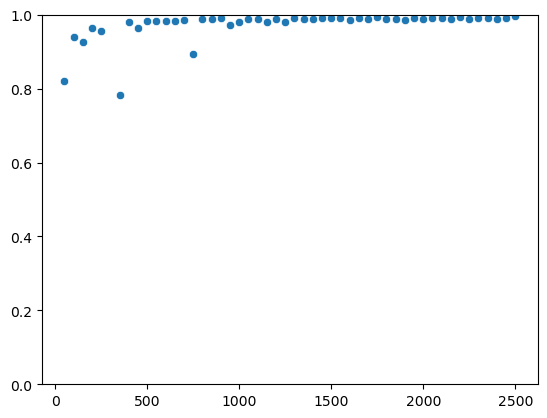

In [102]:
ax = sns.scatterplot(
    x=list(map(lambda x: x[0], r9_identities)),
    y=list(map(lambda x: x[1], r9_identities)),
)
ax.set_ylim((0, 1))
ax.set(ylabel="")

### Basecall R10 signal

In [103]:
r10_identities = []
with start_guppy_server_and_client(
    BIN_PATH,
    "dna_r10.4.1_e8.2_400bps_hac.cfg",
    "ipc:///tmp/.guppy/5555",
    ["--device", "cuda:all"],
) as client:
    fa = Fasta(str(TEST_FASTA.resolve()))
    for signal_array in R10_SQUIGGLE_OUTDIR.rglob("*.npy"):
        # remove any non ACGT and replace with A
        read_id = signal_array.stem.partition(".")[0]
        signal = np.load(signal_array)
        read = {"read_id": read_id, "raw_data": signal}
        success_pass = client.pass_read(read, pack)
    t.sleep(10)
    res = client.get_completed_reads()
    for r in sorted(res, key=lambda x: len(x[0]["datasets"].get("sequence", ""))):
        read_id = r[0]["metadata"]["read_id"]
        reference_fasta = fa[read_id]
        print(reference_fasta)
        print()
        aligner = mp.Aligner(seq=str(reference_fasta), preset="map-ont")
        read_number = r[0]["metadata"]["read_id"].rsplit("_", 3)[-3]
        sequence = r[0]["datasets"].get("sequence", "")
        query_len = len(sequence)
        print(sequence)
        als = aligner.map(sequence)
        for al in als:
            print(al.cigar_str)
            print(calculate_identity(al.cigar_str, al.ctg_len))
            print(
                f"read_id: {r[0]['metadata']['read_id']} \n\tmap_start {al.r_st}, map end {al.r_en}\n\t{len(reference_fasta)}"
            )
            r10_identities.append(
                (al.ctg_len, calculate_identity(al.cigar_str, al.ctg_len))
            )

aaaatatttacagtaacTATGGAACACAAAGGTTTATTACATCCATAATT

TTACAGTAGCTCTGGAACACAAAGGTTTGCTACATCCATAATT
TTGGCACAGAGGCAGCAGAGCAGGGAGGTGAAGAGAGTGGGCTCTGGACCCAGCCTCAGTCCACATCCCGGTTCTGTCCTTTGATGGCCGTGTGAGGATA

AAGGCAGCAAAGCAAATAAAAATCAGGGCTCTGAACCCACCTAGATCCACATACAGATTATGTCCTTGATGGCCATGTCAAGG
AGCTTATTACCTGCTTCCTAAATTTGCCTTTCTCCATCACTGCAATGGCAGCTCCATTCTCCCTGATGCTTAGGCCCCAGGAGCTGTCAACCCTGTCCCCCACATCCAACTCATCTGCAGGTCCTGTCAGCCTTGCCTTCCAGGTGGCCC

ACCTGCTTCCTCGTTCCTTCTCCATCACTGCAATCACGACTCCATTCTCCCTGATGCTTAGGCCCCAGGAGCTGTCAACCCTGTCCCCACATCCAACTCATCTCCGTCCTGTCAGCCTTGCCTTCCAGTCGCT
11M2D4M1D2M1D67M1D21M2D23M
0.8533333333333334
read_id: test_read_3_888598_888748 
	map_start 8, map end 143
	150
GAAGTTGCGCAAACTCAGCTTGCCGGAGCCCCAGGTGGGCCGGGCCGGAGGAGCGCAGGCCAGCGGCGCGGGCGCAGCCGGGTACGTGCGGACCGCGGCGGGGGGCGCCCAGCCGGGGTAGGGGGCGGCCCGAGCACCCCTCCACCCCAGGACGGCGGGAACGGGGCAGGGATCTACCTTTCGGCTTCAAGAGGACCGCG

GCATTGAATTCAAAGTGCAATAGTTCACCTTCAGAAGTCACCAACCCATAGCGGCGCATCGCCGTAATGCAAACCCGACCAAGTGTGCAACCAAATCCAGTCCCGAACATTGCCCTC

[Text(0, 0.5, '')]

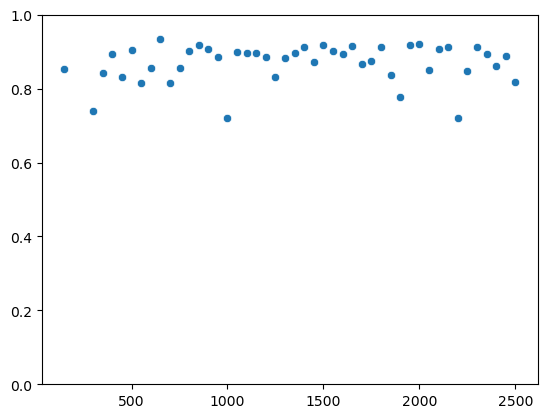

In [104]:
ax = sns.scatterplot(
    x=list(map(lambda x: x[0], r10_identities)),
    y=list(map(lambda x: x[1], r10_identities)),
)
ax.set_ylim((0, 1))
ax.set(ylabel="")

In [107]:
np.mean([x[1] for x in r10_identities])

0.8694454073495055

In [106]:
r10_identities

[(150, 0.8533333333333334),
 (300, 0.7402597402597403),
 (350, 0.8413978494623656),
 (400, 0.8938271604938272),
 (450, 0.8318777292576419),
 (500, 0.9037328094302554),
 (550, 0.8143607705779334),
 (600, 0.8550488599348535),
 (650, 0.9344512195121951),
 (700, 0.8158253751705321),
 (750, 0.8560311284046692),
 (800, 0.9014598540145985),
 (850, 0.9181084198385236),
 (900, 0.9069264069264069),
 (950, 0.8865461847389559),
 (1000, 0.719885277246654),
 (1050, 0.8998144712430427),
 (1100, 0.897302001740644),
 (1150, 0.8974789915966387),
 (1200, 0.8856),
 (1250, 0.8315132605304212),
 (1300, 0.8815406976744186),
 (1350, 0.8959660297239915),
 (1400, 0.913588850174216),
 (1450, 0.8706270627062707),
 (1500, 0.9189889825016202),
 (1550, 0.9024390243902439),
 (1600, 0.8948004836759371),
 (1650, 0.9161816065192084),
 (1700, 0.8661064425770308),
 (1750, 0.8735440931780366),
 (1800, 0.9135338345864662),
 (1850, 0.8364485981308412),
 (1900, 0.778117048346056),
 (1950, 0.9179920477137177),
 (2050, 0.849056